<!-- # 학습 개선방향
### 데이터 
- `04_014_FE.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
    - date_block_num >= 12 로 데이터 고정
    - test 데이터에 존재하는 item_id로 데이터 필터링
    - item_name에 대한 파생 피처 생성
### 학습
- 학습 결과 평가
    - 모델의 예측값과 타겟값을 직접 비교
    - 예측값과 타겟값의 차이가 큰 데이터를 직접 확인
    - 검증(10월) 데이터에 대한 예측값의 평균보다 테스트(11월) 데이터에 대한 예측값의 평균이 낮아야 함. 데이터를 통해 11월의 매출이 1년 중 가장 낮은 것을 확인 -->

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation, record_evaluation

%matplotlib inline
plt.style.use("seaborn-v0_8-white")
pd.options.display.float_format = '{:.6f}'.format

 # Data

In [ ]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data_result.joblib')
all_data.shape,

((8812167, 45),)

In [3]:
all_data[all_data['date_block_num']==34]['item_shop_last_sale'].describe()

count   214200.000000
mean         9.518324
std          9.577601
min          1.000000
25%          2.000000
50%          5.000000
75%         15.000000
max         34.000000
Name: item_shop_last_sale, dtype: float64

In [4]:
all_data[(all_data['date_block_num']<34) & (all_data['item_shop_last_sale']==-1)]

,shop_id,item_id,date_block_num,item_cnt_month,city,item_category_id,platform,meta,type_code,subtype,...,rolling_3m_item_cat_mean,rolling_3m_item_cat_std,rolling_3m_price_mean,rolling_3m_price_std,items_per_transaction_lag_1,item_cnt_month_diff_1,item_cnt_month_diff_2,item_avg_date_sales_diff_1,item_avg_date_sales_diff_2,category_nov_ratio
0,2,19,0,0,1,40,1,9,11,4,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,1.049586
1,2,27,0,1,1,19,4,13,6,10,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,0.993917
205,2,1022,0,0,1,67,1,9,10,52,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,0.911959
206,2,1023,0,2,1,67,1,9,10,52,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,0.911959
526,2,1987,0,2,1,30,3,8,9,55,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,1.001324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8375523,59,19049,32,0,24,58,1,14,12,27,...,0.026103,0.022628,2299.000000,0.000000,0.000000,0,0,-0.024390,0.000000,1.094742
8375903,59,20752,32,0,24,72,1,7,10,59,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,1.041723
8375904,59,20758,32,0,24,72,1,7,10,59,...,0.000000,0.000000,NaN,NaN,0.000000,0,0,0.000000,0.000000,1.041723
8376093,59,21812,32,0,24,40,1,9,11,4,...,0.247190,0.003795,299.000000,0.000000,0.000000,0,0,-0.146341,0.170732,1.049586


In [5]:
print(all_data.duplicated(subset=['date_block_num', 'shop_id', 'item_id']).sum())
print(all_data['date_block_num'].min())

0
0


In [6]:
all_data.loc[all_data['item_age']>=12, 'item_age'] = 12
all_data.loc[all_data['item_shop_age']>=12, 'item_shop_age'] = 12
all_data.loc[all_data['item_shop_last_sale']>=12, 'item_shop_last_sale'] = 12
all_data.loc[all_data['item_shop_last_sale']<0, 'item_shop_last_sale'] = 12

In [7]:
temp = all_data.isna().sum()
print(temp[temp > 0])
del temp

date_item_avg_price_lag_1    2027634
item_avg_price_expanding      782278
rolling_3m_price_mean        1194831
rolling_3m_price_std         1194831
dtype: int64


# Model

## Validation

[100]	train's auc: 0.985438	eval's auc: 0.985485

AUC가 0.990018에 도달했습니다. 학습을 강제 종료합니다.
AUC : 0.9900
>> 경고: Train과 Test의 분포가 상당히 다릅니다. (AUC >> 0.5)
>> 상위 중요도 변수를 확인하고 제거하거나 변환을 고려하세요.


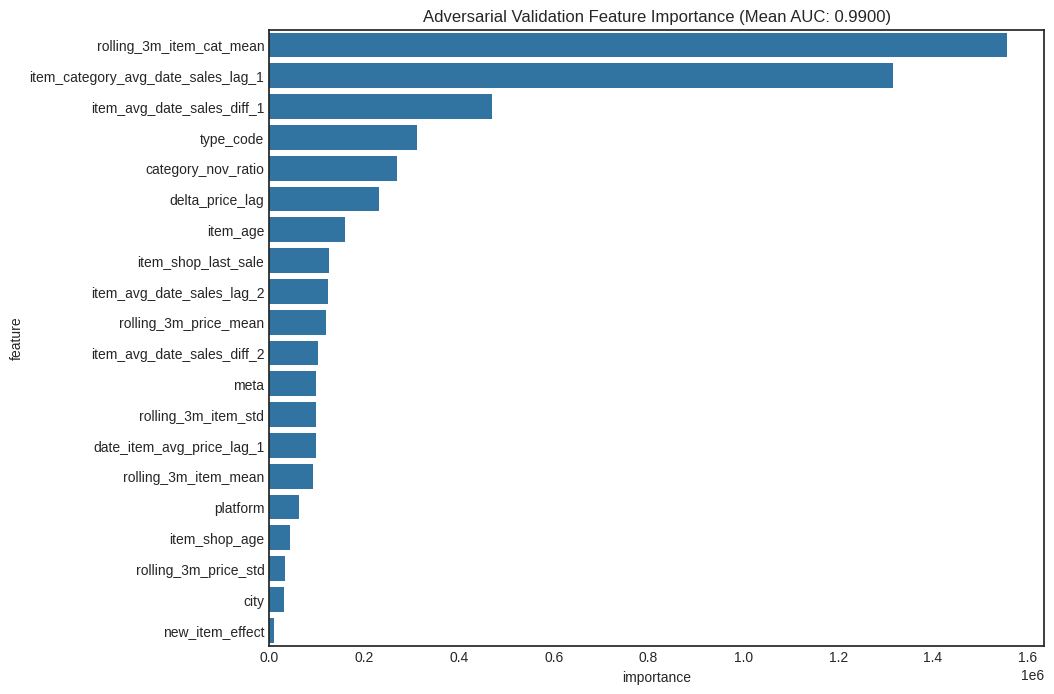


[상위 10개 범인 변수]
                               feature     importance
23            rolling_3m_item_cat_mean 1556469.530198
9   item_category_avg_date_sales_lag_1 1316054.174147
29          item_avg_date_sales_diff_1  469984.961091
3                            type_code  311940.604482
31                  category_nov_ratio  269281.565814
14                     delta_price_lag  230581.251575
15                            item_age  160013.458593
18                 item_shop_last_sale  125667.446802
12           item_avg_date_sales_lag_2  123458.865308
24               rolling_3m_price_mean  120414.016024


In [ ]:
# 데이터 준비
temp = all_data.copy()
temp.loc[temp['item_age']>12, 'item_age'] = 12
temp['target'] = 0
temp.loc[temp['date_block_num']==34, 'target'] = 1
id_cols = ['item_cnt_month', 'date_block_num', 'month']
feat_cols = ['shop_id', 'item_id', 'item_category_id', 'item_avg_date_sales_lag_1', 'category_nov_ratio', 'item_category_avg_date_sales_lag_1', 'rolling_3m_item_cat_mean'] 
drop_cols = id_cols + feat_cols 
df = temp.drop(columns=drop_cols)

def stop_at_perfect_score(env):
    for data_name, metric_name, score, _ in env.evaluation_result_list:
        # eval 셋의 auc가 0.999를 넘으면
        if data_name == 'eval' and metric_name == 'auc' and score > 0.99:
            print(f"\nAUC가 {score:.6f}에 도달했습니다. 학습을 강제 종료합니다.")
            # LightGBM 예외를 발생시켜 학습 중단
            raise lgb.callback.EarlyStopException(env.iteration, env.evaluation_result_list)

# 피처 중요도
features = [col for col in df.columns if 'target' not in col]
feature_imp = pd.DataFrame()
feature_imp['feature'] = features
feature_imp['importance'] = 0

# 모델 설정
cat_features = ['city', 'type_code', 'meta', 'platform']
best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'learning_rate': 0.1, 
    'feature_fraction' : 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'num_leaves' : 30,
    'max_depth' : 5,
}

x = df[features]
y = df['target']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2025, stratify=y)

dtrain = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_features, reference=dtrain)

# 모델 검증
model = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=5000,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'eval'],
    callbacks=[
        log_evaluation(period=100),
        stop_at_perfect_score,
    ]
)

val_preds = model.predict(x_val)
score = roc_auc_score(y_val, val_preds)
feature_imp['importance'] += model.feature_importance(importance_type='gain')
print(f'AUC : {score:.4f}')

if score > 0.7:
    print(">> 경고: Train과 Test의 분포가 상당히 다릅니다. (AUC >> 0.5)")
    print(">> 상위 중요도 변수를 확인하고 제거하거나 변환을 고려하세요.")
elif score > 0.6:
    print(">> 주의: 약간의 분포 차이가 있습니다. 상위 변수를 점검하세요.")
else:
    print(">> 양호: Train과 Test의 분포가 비슷합니다. (AUC ≈ 0.5)")


plt.figure(figsize=(10, 8))
top_features = feature_imp.sort_values(by='importance', ascending=False).head(20)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title(f'Adversarial Validation Feature Importance (Mean AUC: {score:.4f})')
plt.show()

print("\n[상위 10개 범인 변수]")
print(top_features[['feature', 'importance']].head(10))